In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_utils import BasicFunctions, PriceFunctions
from TechnicalAnalysis import TechnicalAnalysis 
from BackTest import Backtester, strategyBacktest
import math
import tensorflow as tf
from scipy.stats import linregress

from IPython.display import HTML

%matplotlib inline
%load_ext autoreload
%autoreload 2

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


btc = quandl.get('BCHARTS/COINBASEUSD', start_date='2017/4/15', end_date='2017/5/15')
eth = quandl.get('GDAX/ETH_USD', start_date='2017/4/15', end_date='2017/5/15')

btc.to_csv('btc.csv')
eth.to_csv('eth.csv')

In [2]:
bf = BasicFunctions()
pf = PriceFunctions()

In [3]:
df = pf.get_pandas(coin='BTC', targetdays=24, absolute=True) #as the data is hourly
ta = TechnicalAnalysis(df, timeframe=[24], period=[14])
ta.merge_time()

df_withta = ta.get_dic()['24hour'] #for merging 24 into 1 for now

In [4]:
# ta = TechnicalAnalysis(df, timeframe=[3,6,12,24], period=[14, 20])
# ta.merge_time()

# ta.perform('obv')
# ta.perform('macd')
# ta.perform('bollingerband')
# ta.perform('volumechange')
# ta.perform('rsi')


# df_withta = ta.get_dataframe()


In [5]:
pd_Xtrain, pd_ytrain, pd_Xtest, pd_ytest = pf.split_traintest(df_withta)

pd_Xtrain_nd = pd_Xtrain.drop('Date', axis=1)
pd_Xtest_nd = pd_Xtest.drop('Date', axis=1)

mean, std, Xtrain, ytrain, Xtest, ytest = pf.get_numpy(pd_Xtrain_nd, pd_ytrain, pd_Xtest_nd, pd_ytest)

In [6]:
def create_placeholders(Xshape, yshape):
    X = tf.placeholder(tf.float32, shape=(None, Xshape), name='X')
    y = tf.placeholder(tf.float32, shape=(None, yshape), name='y')
    
    return X,y

In [7]:
def forward_propagation(X, training):
    Z1 = tf.layers.dense(X, 30, name='Z1', kernel_initializer=tf.keras.initializers.he_normal(seed=1))
    bn1 = tf.layers.batch_normalization(Z1, training=training, name='bn1')
    ac1 = tf.nn.relu(bn1, name='ac1')
    A1 = tf.layers.dropout(ac1, 0.3, name='A1')
    
    Z2 = tf.layers.dense(A1, 15, name='Z2', kernel_initializer=tf.keras.initializers.he_normal(seed=1))
    bn2 = tf.layers.batch_normalization(Z2, training=training, name='bn2')
    ac2 = tf.nn.relu(bn2, name='ac2')
    A2 = tf.layers.dropout(ac2, 0.3, name='A2')
    
    Z3 = tf.layers.dense(A2, 2, name='Z3', kernel_initializer=tf.keras.initializers.he_normal(seed=1))
    #A3 = tf.nn.relu(Z3)

    return Z3

In [8]:
def cost_function(AL, y):
    classcost = tf.reduce_mean(tf.square(y[:, 0] - AL[:, 0]))
    percost = tf.reduce_mean(tf.square(y[:, 1] - AL[:, 1]))
    
    classification  = tf.abs(tf.log(classcost))
    regression = tf.abs(tf.log(percost))
    
    cost = 0.5 * classification + 5 * regression
    
    costs = [cost, classification, regression]
    
    return costs

In [9]:
import os
cwd = os.getcwd()

from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

Iteration: 0
Classification cost: 0.7455035448074341
Regression cost: 0.033775780349969864
Total Clost: 0.1457231342792511


Iteration: 50
Classification cost: 0.10797952115535736
Regression cost: 0.007657025475054979
Total Clost: 0.020830202847719193


Iteration: 100
Classification cost: 0.09215431660413742
Regression cost: 0.015237356536090374
Total Clost: 0.01690712757408619


Iteration: 150
Classification cost: 0.17609737813472748
Regression cost: 0.0031122365035116673
Total Clost: 0.03490825369954109


Iteration: 200
Classification cost: 0.13294163346290588
Regression cost: 0.01882907561957836
Total Clost: 0.024705419316887856


Iteration: 250
Classification cost: 0.1088409423828125
Regression cost: 0.011124021373689175
Total Clost: 0.020655786618590355


Iteration: 300
Classification cost: 0.07839010655879974
Regression cost: 0.017184879630804062
Total Clost: 0.013959532603621483


Iteration: 350
Classification cost: 0.11983142048120499
Regression cost: 0.003670626087114215
Total

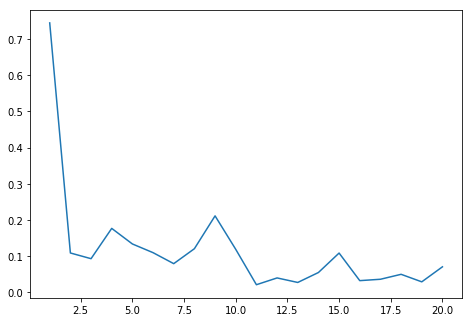

In [78]:
tf.reset_default_graph()

with tf.name_scope('Initialize'):
    X, y = create_placeholders(Xtrain.shape[1], 2)
    training = tf.placeholder(tf.bool, shape=(), name='training')
    
with tf.name_scope('ForwardPropagation'):
    ALtensor = forward_propagation(X, training)
    
with tf.name_scope('CostFunction'):
    cost = cost_function(ALtensor, ytrain)
    
with tf.name_scope('BackPropagation'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005).minimize(cost[0])
    
init = tf.global_variables_initializer()

cost_summary = tf.summary.scalar('Cost', cost[0])
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

costs = []

with tf.Session() as sess:
    sess.run(init)
    mini_batches = bf.initialize_mini_batch(Xtrain, ytrain, batchsize=32)
    
    for i in range(1000):
        for batch in mini_batches:
            (Xbatch, ybatch) = batch
            sess.run(optimizer, feed_dict={X: Xbatch, y: ybatch, training: True})
            
        if (i % 50 == 0):
            cost_str = cost_summary.eval(feed_dict={X: Xbatch, y: ybatch, training: True})
            
            cost0 = cost[0].eval(feed_dict={X: Xbatch, y: ybatch, training: True})
            cost1 = cost[1].eval(feed_dict={X: Xbatch, y: ybatch, training: True})
            cost2 = cost[2].eval(feed_dict={X: Xbatch, y: ybatch, training: True})
            
            costs.append(cost0)
            
            print("Iteration: {}\nClassification cost: {}\nRegression cost: {}\nTotal Clost: {}\n\n".format(i, cost0, cost1, cost2))
            
            file_writer.add_summary(cost_str, i)
            
    
    saver = tf.train.Saver()
    saver.save(sess, cwd + '/tf_logs/session/session.chkp')
    file_writer.close()
    
bf.single_plot(costs, log=False)

In [79]:
def sigmoid(Z):
    return (1/(1+np.exp(-Z)))

def calculate_accuracy(AL, y):
    #calculate accuracy, precision, recall and F1 value here too
    ALc = AL[:, 0]
    yc = y[:, 0]
    
    ALc = ALc > 0.5
    ALc = ALc.astype(int)
    
    total = ALc.shape[0]
    
    TP = np.sum(np.logical_and(ALc==1, yc==1))
    TN = np.sum(np.logical_and(ALc==0, yc==0))
    
    FP = np.sum(np.logical_and(ALc==1, yc==0))
    FN = np.sum(np.logical_and(ALc==0, yc==1))
    
    P = TP / (TP + FP)
    R = TP / (TP + TN)
    F1 = (2 * P * R) / (P + R)
    
    
    acc = np.sum(ALc == yc)/total
    
    
    print("\nAccuracy: {} \n".format(acc))
    print("True Positive: {} \nTrue Negative: {}\nFalse Positive: {} \nFalse Negative: {}\n".format(TP, TN, FP, FN))
    print("Precision: {} \nRecall: {} \nF1 Score: {}\n".format(P, R, F1))
    
    
    ALcr = AL[:, 1]
    ycr = y[:, 1]

    fig, axes = plt.subplots(figsize=(12,6))
    axes.plot(ALcr, label="Predicted Value")
    axes.plot(ycr, label="Actual Value")
    axes.set_ylabel("Percentage Change")
    axes.set_title("Regression Comparision")
    axes.legend(loc=4)
    
    slope, intercept, rval, pval, stderr = linregress(ycr, ALcr)
    print("R-Value: " + str(rval)) #rvalue is between -1 and 1 and can be used for single. Suitable for my purpose. R2 can be used for multiple, gives one and zero
    
    maximum = max(ycr.max(),AL.max())
    minimum = min(ycr.min(),ALcr.min())
    fig2, ax2 = plt.subplots(figsize=(12,6))
    ax2.scatter(ycr,ALcr)
    ax2.plot([minimum, maximum], [minimum, maximum], 'r-', lw=2)
    
    #plot this
    return AL, y

INFO:tensorflow:Restoring parameters from C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor/tf_logs/session/session.chkp

Accuracy: 0.5147058823529411 

True Positive: 499 
True Negative: 271
False Positive: 423 
False Negative: 303

Precision: 0.5412147505422994 
Recall: 0.6480519480519481 
F1 Score: 0.5898345153664304

R-Value: 0.04655431655113583


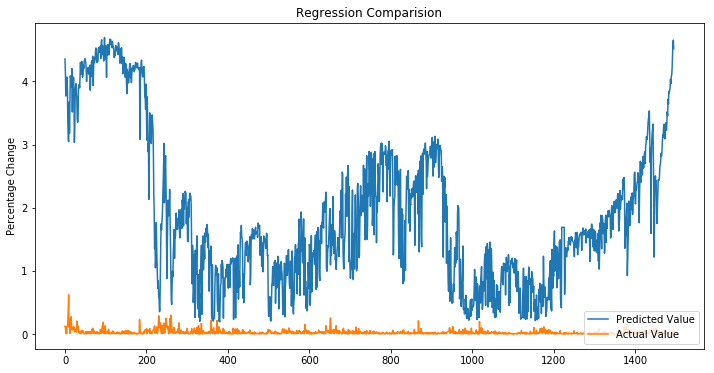

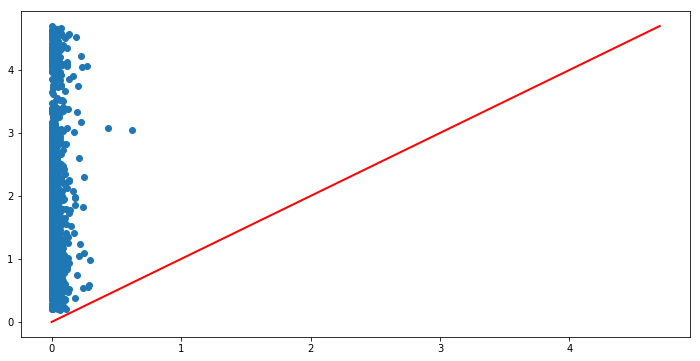

In [80]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, cwd + '/tf_logs/session/session.chkp')
    
    Z = sess.run(ALtensor, feed_dict={X: Xtrain, training: False})
    Z[:, 0] = sigmoid(Z[:, 0])
    
    AL, y = calculate_accuracy(Z, ytrain)

INFO:tensorflow:Restoring parameters from C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor/tf_logs/session/session.chkp


c:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars



Accuracy: 0.44299674267100975 

True Positive: 0 
True Negative: 136
False Positive: 0 
False Negative: 171

Precision: nan 
Recall: 0.0 
F1 Score: nan

R-Value: 0.17648193031113144


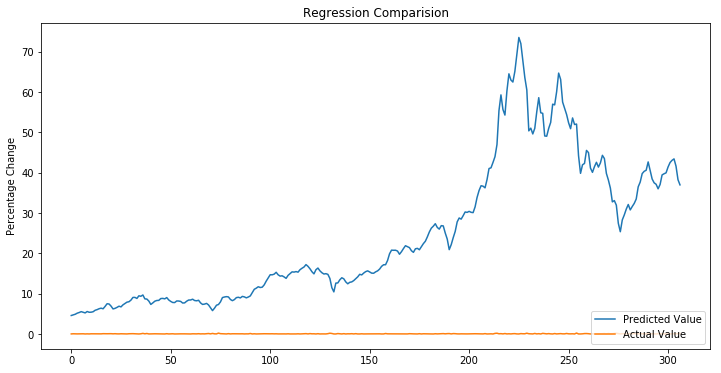

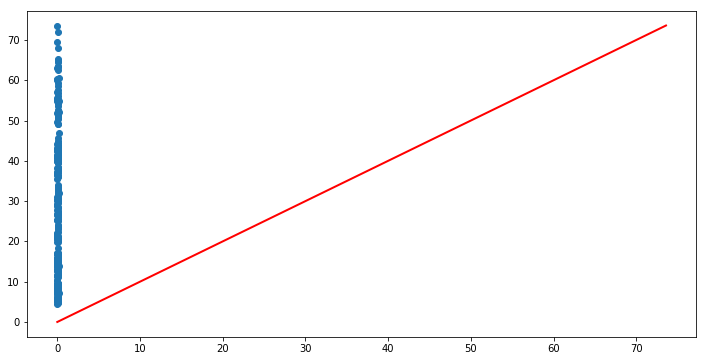

In [82]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, cwd + '/tf_logs/session/session.chkp')
    
    Z = sess.run(ALtensor, feed_dict={X: Xtest, training: False})
    Z[:, 0] = sigmoid(Z[:, 0])
    
    ALtest, _ = calculate_accuracy(Z, ytest)

In [83]:
pd_ytrain_mod = pd_ytrain.reset_index(drop=True)
combined = pd.concat([pd_Xtrain, pd_ytrain_mod], axis=1)

In [43]:
bars = {}
bars['BTC'] = combined

signals = {}
signals['BTC'] = AL

C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\backtester.py:225: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\backtester.py:227: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newData = pd.Series({'Date': date, 'Coin': coin, 'Price': currprice[coin], 'Bankroll': oldBankroll+closingChange, 'Amount': abs(amount), 'Type': 'CLOSE', 'Position': signal, 'Status': 'INACTIVE'})


Portfolio Stats:
Total Return: -100.0%
Sharpe Ratio: nan Calmar Ratio: nan Sortino Ratio: nan Maximum Drawdown: -100.0%

BTC Portfolio:
Total Return: 1385.69%
Sharpe Ratio: 1.187 Calmar Ratio: 0.008 Sortino Ratio: 1.499 Maximum Drawdown: -36.42%


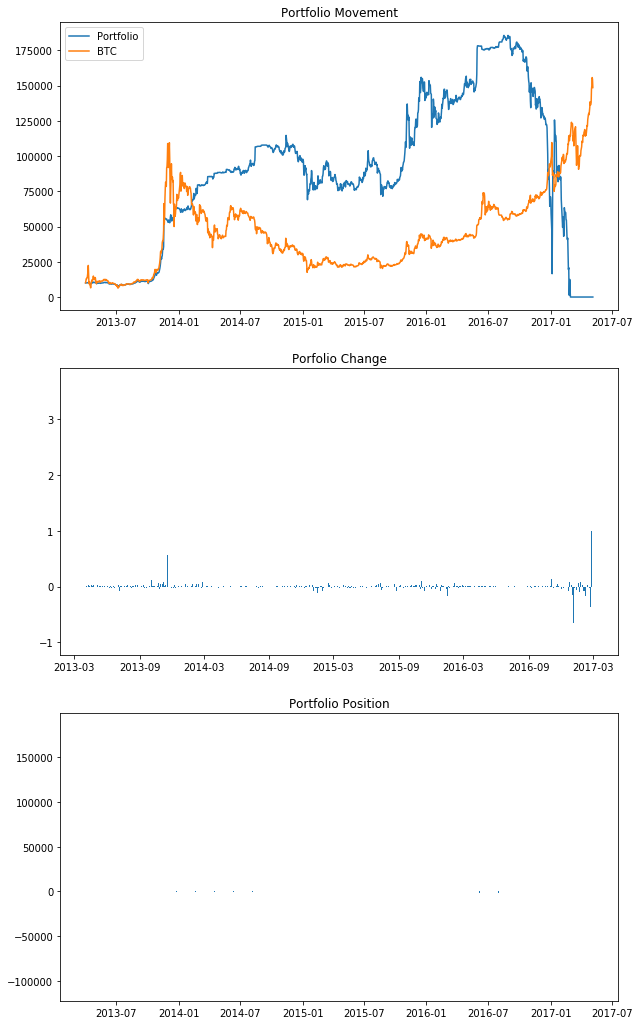

In [71]:
bt = Backtester(bars, signals, comission=0.1, maxper=0.01) #bars should contain 
bt.perform_backtest()
positions = bt.get_positions()
bt.get_outcome()

In [84]:
pd_ytest_mod = pd_ytest.reset_index(drop=True)
combinedTest = pd.concat([pd_Xtest, pd_ytest_mod], axis=1)

barsTest = {}
barsTest['BTC'] = combinedTest

signalsTest = {}
signalsTest['BTC'] = ALtest

C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\backtester.py:225: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\backtester.py:227: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newData = pd.Series({'Date': date, 'Coin': coin, 'Price': currprice[coin], 'Bankroll': oldBankroll+closingChange, 'Amount': abs(amount), 'Type': 'CLOSE', 'Position': signal, 'Status': 'INACTIVE'})


Portfolio Stats:
Total Return: -100.0%
Sharpe Ratio: nan Calmar Ratio: nan Sortino Ratio: nan Maximum Drawdown: -100.0%

BTC Portfolio:
Total Return: 520.42%
Sharpe Ratio: 2.496 Calmar Ratio: -inf Sortino Ratio: 3.938 Maximum Drawdown: 0.0%


C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\calculations.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = (np.average(percentage)/drawDown)


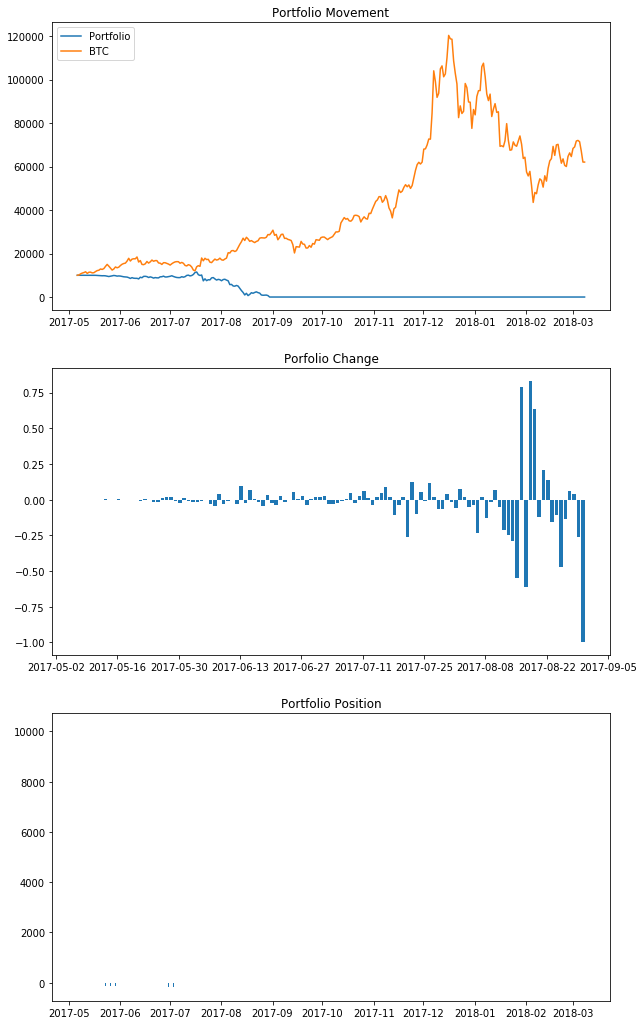

In [85]:
bt1 = Backtester(barsTest, signalsTest, comission=0.1, maxper=0.01) #bars should contain 
bt1.perform_backtest()
positions = bt1.get_positions()
bt1.get_outcome()